
...Processing ASCII data of file: 
/u/ayannam/Documents/Test_Files/out_47_parents.list
 
Total number of rows in detected data = 3472419
Number of rows in detected header = 16 

... working on chunk 0 of 2
... working on chunk 1 of 2
Total runtime to read in ASCII = 20.41 seconds




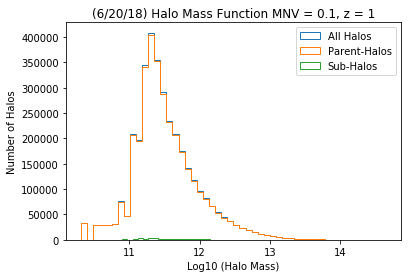

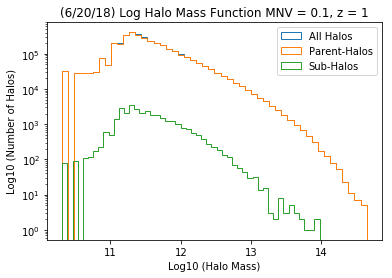

In [9]:
# -*- coding: utf-8 -*-

# Processes Halo Data from Halo Catalogs

import sys, os
import numpy as np
from matplotlib import pyplot as plt
from halotools import sim_manager
from scipy.fftpack import fftfreq, fftshift, ifftshift, ifftn
#from emcee.utils import MPIPool

Lbox = 512.0 # size of box in Mpc/h
Ngrid = 256.0 # number of cells in 1D of grid for power spectrum

bin_centers = np.arange(Ngrid) # integer linear space up to number of cells for as bin centers
Lgrid = Lbox / Ngrid # the size of each individual grid cell

# directories, sub directories, and out list files for subhalo and parent halo catelogs
subhalo_main_dir = "~/temp/"
subhalo_cosmo_tup = ("mnv0.00000_om0.30000_As2.1000/", "mnv0.10000_om0.30000_As2.1000/", "mnv0.60000_om0.30000_As2.1000/")
subhalo_out_tup = ("out_37.list", "out_42.list", "out_47.list", "out_56.list", "out_66.list")

parent_main_dir = "/tigress/ayannam/"
parent_cosmo_tup = ("mnv_0.0", "mnv_0.1", "mnv_0.6")
subhalo_out_tup = ("out_37_parents.list", "out_42_parents.list", "out_47_parents.list", "out_56_parents.list", "out_66_parents.list")

headers_str = "#ID DescID Mvir Vmax Vrms Rvir Rs Np X Y Z VX VY VZ JX JY JZ Spin rs_klypin Mvir_all M200b M200c M500c M2500c Xoff Voff spin_bullock b_to_a c_to_a A[x] A[y] A[z] b_to_a(500c) c_to_a(500c) A[x](500c) A[y](500c) A[z](500c) T/|U| M_pe_Behroozi M_pe_Diemer Halfmass_Radius PID"
headers_tup = tuple(headers_str.split(" "))

columns_dict ={
		"halo_id": 	(0, 'i8'),
		"halo_mvir": 	(2, 'f4'),
		"halo_x": 	(8, 'f4'),
		"halo_y": 	(9, 'f4'),
		"halo_z": 	(10,'f4'),
		"PID":		(41,'i8')
	       }

def read_cat(cat_filename):
   # returns a matrix with each halo as the row and x, y, z positions as the columns, array of the log10 of the halo masses, and the PID array
   # must use 3D accessing to access postions and 2D accessing to access the masses where the second dimension is the halo
   reader = sim_manager.TabularAsciiReader(cat_filename, columns_dict)
   halo_arr = reader.read_ascii() # array of tuples containing values for each item in columns_dict
   halo_pos_arr = np.array([halo_arr["halo_x"], halo_arr["halo_y"], halo_arr["halo_z"]]).T #array of arrays containing the x, y, z positions of the halo
   halo_mass_arr = np.log10(halo_arr["halo_mvir"]) # array of log base 10 of the halo masses
   
   halo_PID_arr = np.array(halo_arr["PID"])
   return halo_pos_arr, halo_mass_arr, halo_PID_arr


def plot_halo_mass(cat_filename):

   mass_arr, PID_arr = read_cat(cat_filename)[1:] # mass and PID of all the halos
   

   parents_mask = PID_arr == -1 # boolean array with True for parent halos and False for subhalos
   subhalo_mask = PID_arr != -1 # boolean array with True for subhalos and False for parent halos
    
   plt.hist(mass_arr, bins = 50, label = "All Halos", histtype = "step") # plots mass function of all of the halos
   plt.hist(mass_arr[parents_mask], bins = 50, label = "Parent-Halos", histtype = "step") # plots the mass function of the parent halos
   plt.hist(mass_arr[subhalo_mask], bins = 50, label = "Sub-Halos", histtype = "step") # plots the mass function of the subhalos

   plt.title("(6/20/18) Halo Mass Function MNV = 0.1, z = 1")
   plt.xlabel("Log10 (Halo Mass)")
   plt.ylabel("Number of Halos")
   plt.legend()
   plt.show()

   plt.hist(mass_arr, bins = 50, label = "All Halos", histtype = "step") # plots mass function of all of the halos
   plt.hist(mass_arr[parents_mask], bins = 50, label = "Parent-Halos", histtype = "step") # plots the mass function of the parent halos
   plt.hist(mass_arr[subhalo_mask], bins = 50, label = "Sub-Halos", histtype = "step") # plots the mass function of the subhalos
   
   plt.title("(6/20/18) Log Halo Mass Function MNV = 0.1, z = 1")
   plt.xlabel("Log10 (Halo Mass)")
   plt.ylabel("Log10 (Number of Halos)")
   plt.yscale('log')
   plt.legend()
   plt.show()
    
plot_halo_mass("/u/ayannam/Documents/Test_Files/out_47_parents.list")


...Processing ASCII data of file: 
/u/ayannam/Documents/Test_Files/out_47_parents.list
 
Total number of rows in detected data = 3472419
Number of rows in detected header = 16 

... working on chunk 0 of 2
... working on chunk 1 of 2
Total runtime to read in ASCII = 20.49 seconds




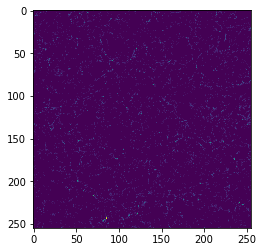

In [7]:
def get_positions(cat_filename):
    # returns a matrix of halo positions with individual halos being rows and x, y, z positions being columns
    return read_cat(cat_filename)[0]

#print(get_positions("/u/ayannam/Documents/Test_Files/test_halo_process.list"))

def get_masses(cat_filename):
    # returns an array of halo masses with the individual halos being the index/ columns
    return read_cat(cat_filename)[1]

#print(get_positions("/u/ayannam/Documents/Test_Files/test_halo_process.list"))

def gridding(halo_positions):
    # returns a 3D grid of the density of halos
    grid = np.histogramdd(halo_positions / Lgrid, bins = [bin_centers, bin_centers, bin_centers])[0]
    grid = grid / np.mean(grid) - 1
    return grid

def plotGrid(cat_filename, plane_ind):
    p = get_positions(cat_filename)
    g = gridding(p)
    plt.imshow(g[plane_ind])
    plt.show()

plotGrid("/u/ayannam/Documents/Test_Files/out_47_parents.list", 128)